<a href="https://colab.research.google.com/github/MatteoAldovardi92/Taxi_Project/blob/main/Preprocessing_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [244]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mnavas/taxi-routes-for-mexico-city-and-quito")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/taxi-routes-for-mexico-city-and-quito


In [245]:
import os

# Show files inside the dataset directory
print("Dataset contents:")
for root, dirs, files in os.walk(path):
    for name in files:
        print(os.path.join(root, name))


Dataset contents:
/kaggle/input/taxi-routes-for-mexico-city-and-quito/mex_clean.csv
/kaggle/input/taxi-routes-for-mexico-city-and-quito/uio_clean.csv
/kaggle/input/taxi-routes-for-mexico-city-and-quito/all-data_clean.csv
/kaggle/input/taxi-routes-for-mexico-city-and-quito/bog_clean.csv


In [246]:
import pandas as pd
import kagglehub
import os

# Download the dataset
path = kagglehub.dataset_download("mnavas/taxi-routes-for-mexico-city-and-quito")

# Load each CSV as a separate DataFrame
bog_df = pd.read_csv(os.path.join(path, "bog_clean.csv"))
uio_df = pd.read_csv(os.path.join(path, "uio_clean.csv"))
mex_df = pd.read_csv(os.path.join(path, "mex_clean.csv"))
all_df = pd.read_csv(os.path.join(path, "all-data_clean.csv"))

# Preview one
print(all_df.head())


   id              vendor_id      pickup_datetime     dropoff_datetime  \
0   1                  Quito  2016-09-17 09:32:06  2016-09-17 10:05:51   
1   2  Guadalajara Easy Taxi  2016-09-17 09:59:54  2016-09-17 10:06:23   
2   3              Monterrey  2016-09-17 10:06:52  2016-09-17 10:09:40   
3   4              Monterrey  2016-09-17 09:45:56  2016-09-17 10:13:34   
4   5              Monterrey  2016-09-17 10:12:00  2016-09-17 10:16:31   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0          0.632055         0.528947         -78.549447         -0.361363   
1          0.327804         0.391950        -103.366600         20.686971   
2          0.140910         0.563280        -100.165737         25.619387   
3          0.207565         0.590416        -100.491721         25.676294   
4          0.128881         0.580419        -100.104166         25.643862   

  store_and_fwd_flag  trip_duration  dist_meters  wait_sec  
0                  N           

# Library of functions for an easier preprocessing

In [247]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

def plot_kmeans_clusters(df, location_type='pickup', n_clusters=2, save = False):
    """
    Plots KMeans clusters for pickup or dropoff locations and returns the fitted KMeans object.

    Parameters:
    - df: DataFrame containing latitude and longitude columns.
    - location_type: 'pickup' or 'dropoff' to specify which columns to use.
    - n_clusters: number of clusters for KMeans.

    Returns:
    - kmeans: trained KMeans object.
    """
    assert location_type in ['pickup', 'dropoff'], "location_type must be 'pickup' or 'dropoff'"

    lat_col = f'{location_type}_latitude'
    lon_col = f'{location_type}_longitude'

    # Extract coordinates and convert to numpy array
    coordinates = np.array(list(zip(df[lat_col], df[lon_col])))

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(coordinates)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Prepare DataFrame for plotting
    df_plot = pd.DataFrame(coordinates, columns=['latitude', 'longitude'])
    df_plot['cluster'] = labels

    # Plot
    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black', 'gray']

    for i in range(n_clusters):
        cluster_points = df_plot[df_plot['cluster'] == i]
        color = colors[i % len(colors)]
        plt.scatter(cluster_points['longitude'], cluster_points['latitude'],
                    color=color, label=f'Cluster {i}', s=20, alpha=0.5)

    plt.scatter(centroids[:, 1], centroids[:, 0], color='black', marker='*', s=100, label='Centroids')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Clusters of {location_type.capitalize()} Locations')
    plt.legend()
    if save == True:
        plt.savefig(f'{location_type}_cluster.jpg')
    plt.grid(True)
    plt.show()

    return kmeans, coordinates


In [248]:
from geopy.distance import geodesic

def clip_km_away(locations, city_center, radius):
    """
    Filters out points that are more than 100 km away from the city center.

    Parameters:
    - locations: list of tuples (lat, long)
    - city_center: tuple (lat, long)

    Returns:
    - list of tuples (lat, long) within 100 km of the city center
    """
    return [geodesic(loc, city_center).km <= radius for loc in locations]

# Feature exploration

In [249]:
bog_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,Bogotá,2016-09-18 01:54:11,2016-09-18 02:17:49,-74.170353,4.622699,-74.119259,4.572322,N,1419,11935,293
1,2,Bogotá,2016-09-18 03:31:05,2016-09-18 03:44:06,-74.123542,4.604075,-74.116125,4.572578,N,782,7101,139
2,3,Bogotá,2016-08-07 03:35:36,2016-09-18 04:30:31,-74.178643,4.646176,-74.178711,4.646367,N,3632095,2655,2534
3,4,Bogotá,2016-09-18 04:31:13,2016-09-18 04:32:19,-74.163398,4.641949,-74.165813,4.640649,N,66,318,52
4,5,Bogotá,2016-09-13 12:07:04,2016-09-18 05:00:44,-74.137539,4.596347,-74.125364,4.576745,N,449620,3228,211


In [250]:
bog_df["wait_sec"].describe()

,wait_sec
count,3.063000e+03
mean,9.652921e+05
std,3.757377e+07
min,0.000000e+00
25%,9.100000e+01
50%,3.000000e+02
75%,8.445000e+02
max,1.471920e+09


In [251]:
bog_df["wait_sec"].value_counts()

,count
wait_sec,
0,60
1,17
10,16
4,15
114535,15
...,...
17655,1
5565,1
1852,1


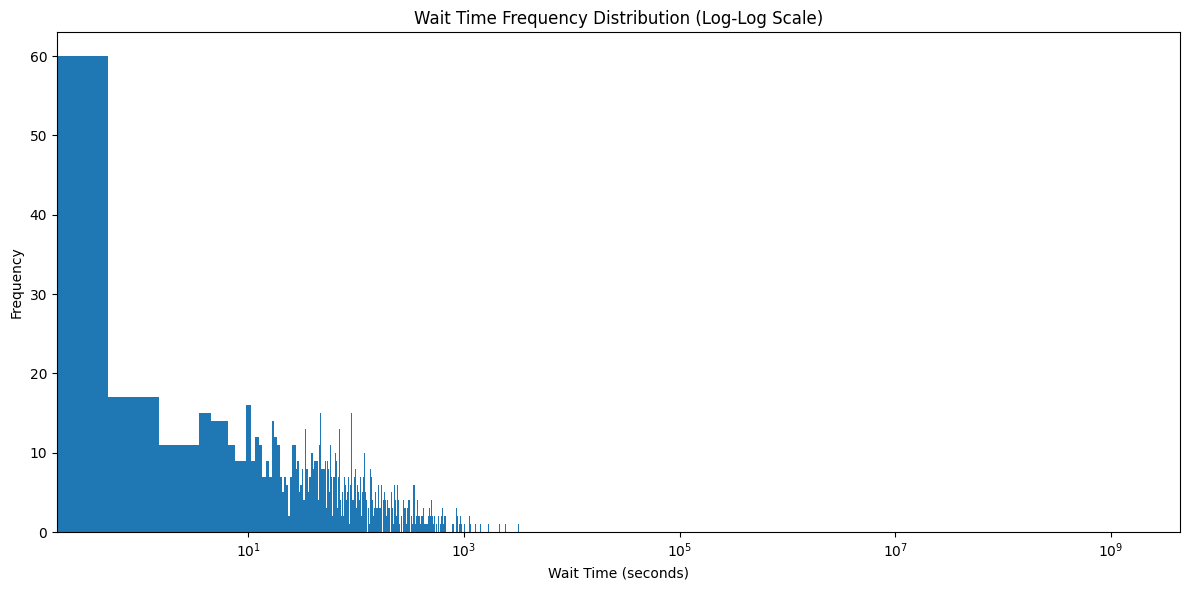

In [252]:
import matplotlib.pyplot as plt

counts = bog_df["wait_sec"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values, width=1.0)

plt.xscale('log')  # Key line: spreads out x-axis


plt.xlabel("Wait Time (seconds)")
plt.ylabel("Frequency")
plt.title("Wait Time Frequency Distribution (Log-Log Scale)")
plt.tight_layout()
plt.show()


# Filter latitudes and longitudes

Prehentively exclude every point into a 100 km radius outside the city

In [253]:
pickup_locations_bg = bog_df[['pickup_latitude', 'pickup_longitude']].values
bogota = (4.7110, -74.0721)

mask1_bg = clip_km_away(pickup_locations_bg, bogota, 60)

bog_df = bog_df[mask1_bg]



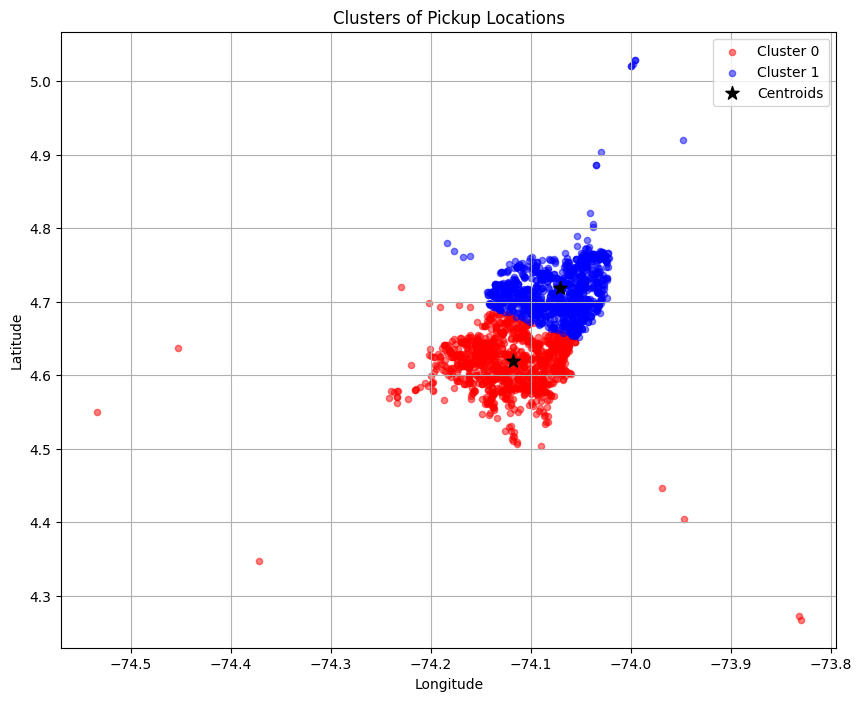

In [254]:
kmeans1_bg = plot_kmeans_clusters(bog_df, location_type='pickup', n_clusters=2, save = False)

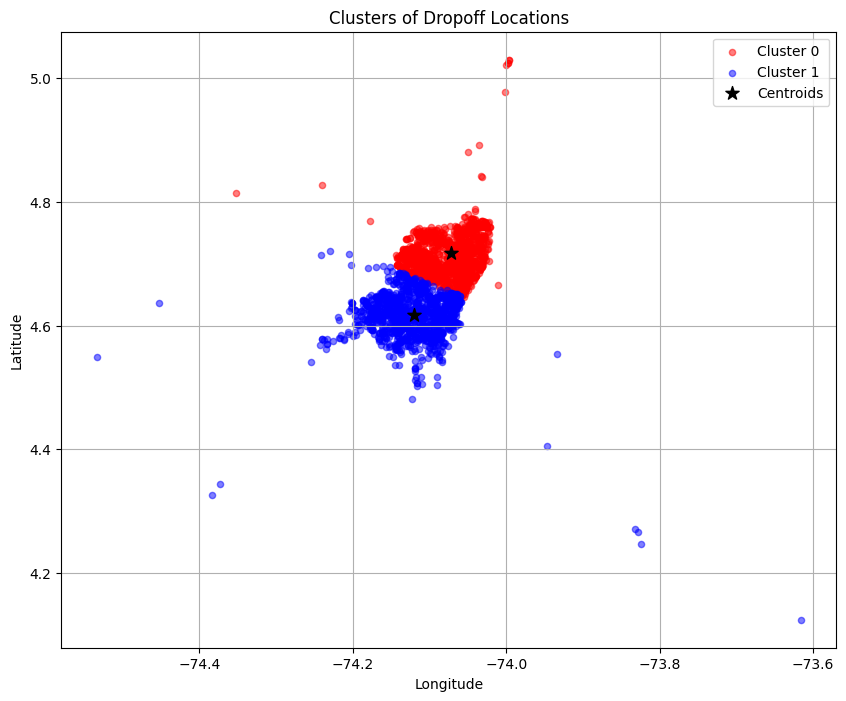

In [255]:
kmeans2_bg = plot_kmeans_clusters(bog_df, location_type='dropoff', n_clusters=2, save = False)

In [256]:
kmeans1_bg[0].inertia_

7.919958615228937

In [257]:
kmeans2_bg[0].inertia_

9.13600052385123

In [258]:
pickup_locations_mex = mex_df[['pickup_latitude', 'pickup_longitude']].values
mexico_city = (19.42847,-99.12766)

mask1_mex = clip_km_away(pickup_locations_mex, mexico_city, 60)

mex_df = mex_df[mask1_mex]


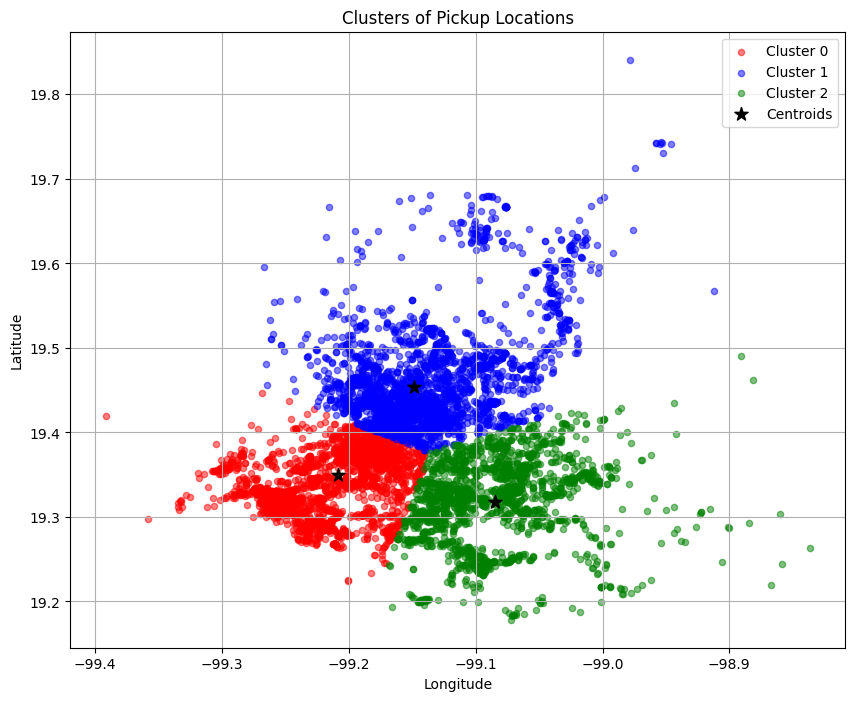

In [259]:
kmeans1_mex = plot_kmeans_clusters(mex_df, location_type='pickup', n_clusters=3, save = False)

In [260]:
kmeans1_mex[0].inertia_

43.468004690759656

In [261]:
pickup_locations_uio = uio_df[['pickup_latitude', 'pickup_longitude']].values

quito = (-0.22985, -78.52495)

mask1_uio = clip_km_away(pickup_locations_uio, quito, 60)

uio_df = uio_df[mask1_uio]

In [262]:
uio_df

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.503922,-0.232824,-78.549447,-0.361363,N,2025,24228,346
1,2,Quito,2016-09-18 04:03:20,2016-09-18 04:26:30,-78.440306,0.006789,-78.490786,-0.104836,N,1390,16680,456
2,3,Quito,2016-09-16 06:29:36,2016-09-18 06:41:33,-78.469551,-0.143636,-78.470277,-0.131083,N,130317,1987,290
3,4,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.558076,-0.278241,-78.430220,-0.201934,N,1933,25146,302
4,5,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.521818,-0.208480,-78.504558,-0.222462,N,948,4625,314
...,...,...,...,...,...,...,...,...,...,...,...,...
32361,32362,Quito,2016-10-27 08:36:09,2016-10-27 09:19:59,-78.485382,-0.174790,-78.487138,-0.175598,N,2631,4872,2006
32362,32363,Quito,2016-10-27 09:30:21,2016-10-28 05:32:38,-78.377726,-0.212579,-78.388333,-0.190998,N,28938,2906,31
32363,32364,Quito,2016-10-27 12:10:18,2016-10-27 06:33:53,-78.477247,-0.107514,-78.490093,-0.100859,N,66216,23607,958
32364,32365,Quito,2016-10-25 04:58:55,2016-10-25 05:00:25,-78.550264,-0.256730,-78.550306,-0.256756,N,91,43,70


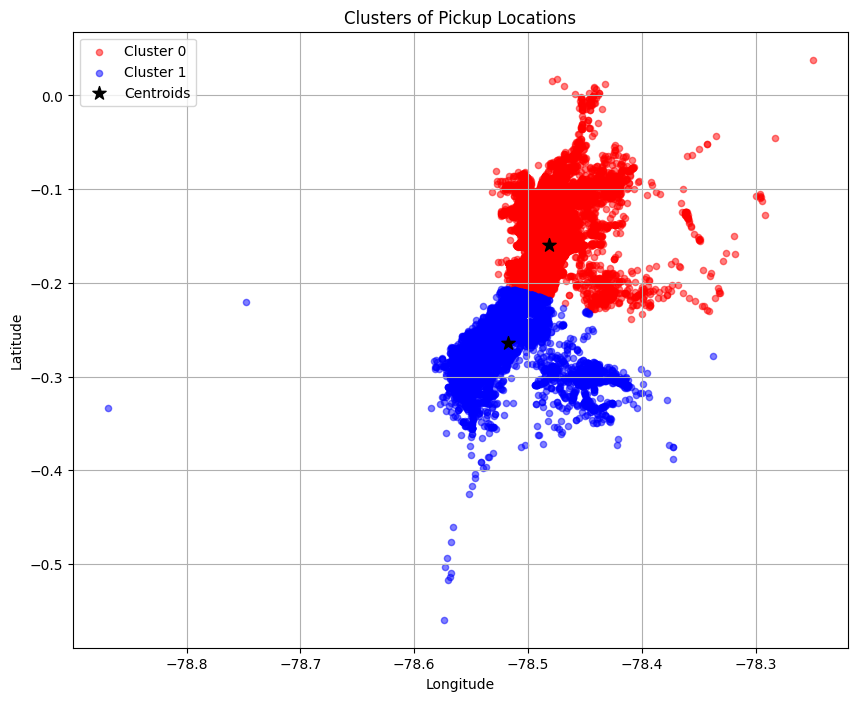

In [263]:
kmeans1_uio  = plot_kmeans_clusters(uio_df, location_type='pickup', n_clusters=2, save = False)

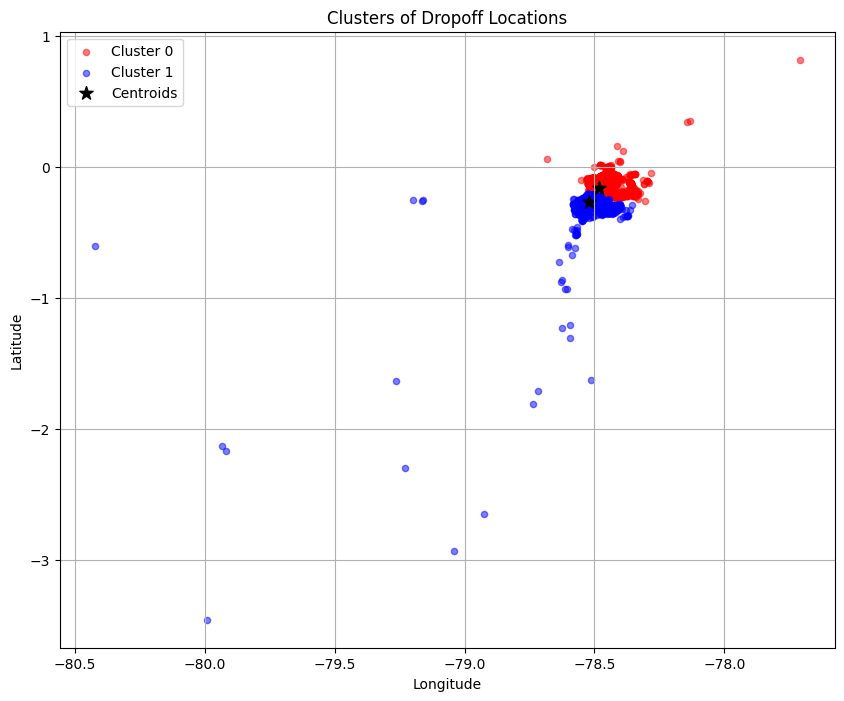

In [264]:
kmeans2_uio  = plot_kmeans_clusters(uio_df, location_type='dropoff', n_clusters=2, save = False)

In [265]:
dropoff_locations_uio = uio_df[['dropoff_latitude', 'dropoff_longitude']].values

quito = (-0.22985, -78.52495)

mask2_uio = clip_km_away(dropoff_locations_uio, quito, 60)

uio_df = uio_df[mask2_uio]

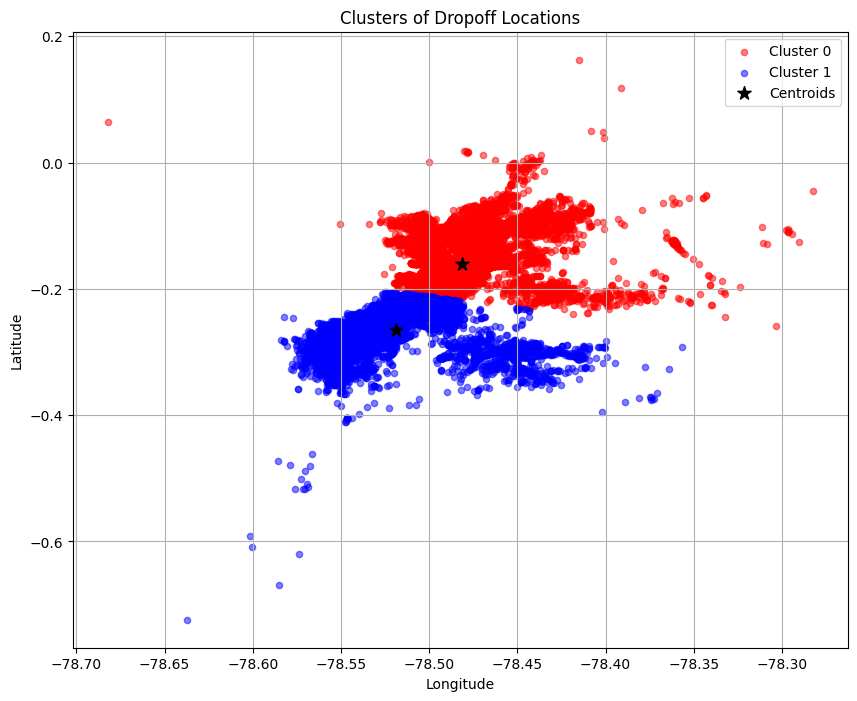

In [266]:
kmeans1_uio  = plot_kmeans_clusters(uio_df, location_type='dropoff', n_clusters=2, save = False)

In [267]:
dropoff_locations_bog = bog_df[['dropoff_latitude', 'dropoff_longitude']].values

mask2_bog = clip_km_away(dropoff_locations_bog, bogota, 60)

bog_df = bog_df[mask2_bog]

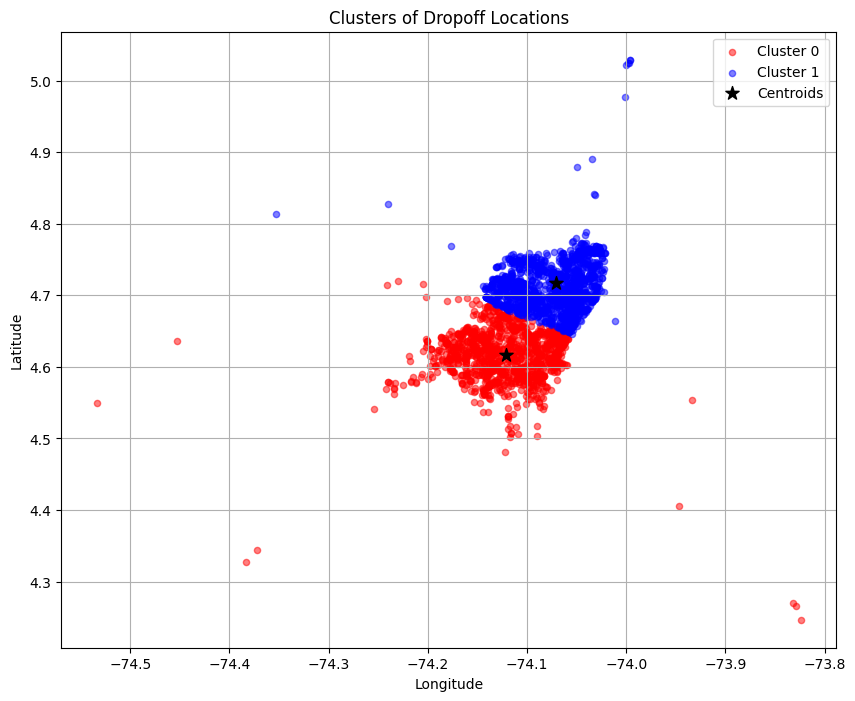

In [268]:
kmeans2_bog = plot_kmeans_clusters(bog_df, location_type='dropoff', n_clusters=2, save = False)

In [269]:
dropoff_locations_mex = mex_df[['dropoff_latitude', 'dropoff_longitude']].values

mask2_mex = clip_km_away(dropoff_locations_mex, mexico_city, 60)

mex_df = mex_df[mask2_mex]

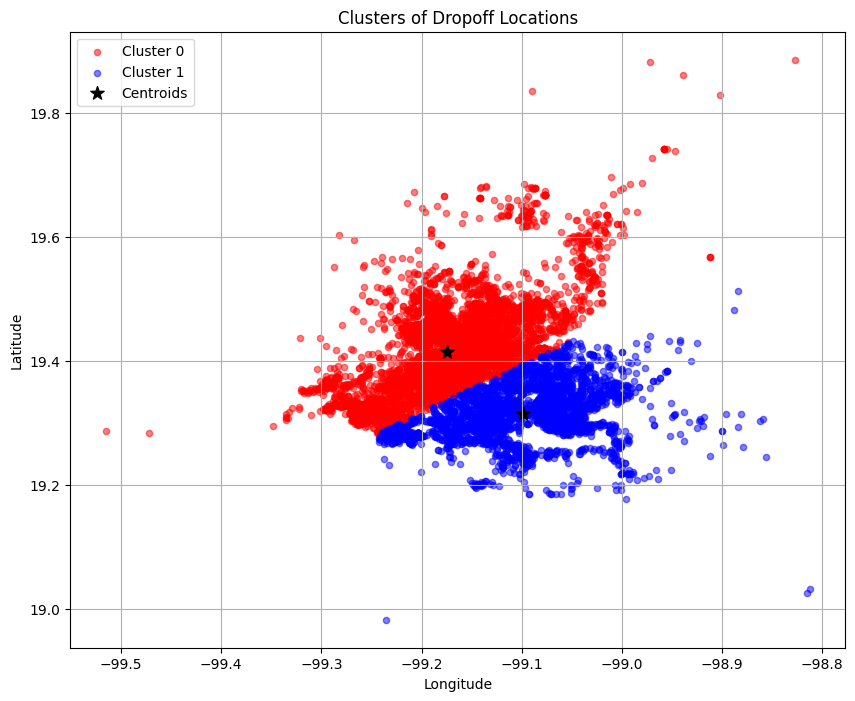

In [270]:
kmeans2_bog = plot_kmeans_clusters(mex_df, location_type='dropoff', n_clusters=2, save = False)

# Save the filtered dataset:

In [271]:
import pandas as pd

# Add city name to each dataframe
mex_df['city_id'] = 'mexico'
bog_df['city_id'] = 'bogota'
uio_df['city_id'] = 'quito'

# Drop old 'id' columns if they exist
for df in [mex_df, bog_df, uio_df]:
    if 'id' in df.columns:
        df.drop(columns=['id'], inplace=True)

# Combine the dataframes
combined_df = pd.concat([mex_df, bog_df, uio_df], ignore_index=True)

# Set new 'id' column from index
combined_df.reset_index(inplace=True)
combined_df.rename(columns={'index': 'id'}, inplace=True)

# Save to CSV
combined_df.to_csv('combined_dataset.csv', index=False)

print("Combined dataset saved to 'combined_dataset.csv'")



<ipython-input-271-f377ca11a6f4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uio_df['city_id'] = 'quito'
<ipython-input-271-f377ca11a6f4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['id'], inplace=True)


Combined dataset saved to 'combined_dataset.csv'


In [273]:
combined_df.iloc[0:,:]

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec,city_id
0,0,México DF Taxi de Sitio,2016-09-16 07:14:12,2016-09-18 04:41:40,-99.097369,19.416874,-99.202729,19.430353,N,120449,12373,242,mexico
1,1,México DF Taxi Libre,2016-09-18 06:16:33,2016-09-18 10:11:43,-99.297148,19.322128,-99.289949,19.326538,N,14110,1700,461,mexico
2,2,México DF Taxi Libre,2016-09-18 10:11:50,2016-09-18 10:23:11,-99.289603,19.326263,-99.271874,19.328530,N,681,2848,129,mexico
3,3,México DF Taxi Libre,2016-09-18 10:23:38,2016-09-18 10:30:53,-99.271161,19.328875,-99.279900,19.326256,N,436,1409,106,mexico
4,4,México DF Taxi Libre,2016-09-18 10:44:18,2016-09-18 10:51:40,-99.282761,19.326944,-99.291705,19.322754,N,442,1567,85,mexico
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47997,47997,Quito,2016-10-27 08:36:09,2016-10-27 09:19:59,-78.485382,-0.174790,-78.487138,-0.175598,N,2631,4872,2006,quito
47998,47998,Quito,2016-10-27 09:30:21,2016-10-28 05:32:38,-78.377726,-0.212579,-78.388333,-0.190998,N,28938,2906,31,quito
47999,47999,Quito,2016-10-27 12:10:18,2016-10-27 06:33:53,-78.477247,-0.107514,-78.490093,-0.100859,N,66216,23607,958,quito
48000,48000,Quito,2016-10-25 04:58:55,2016-10-25 05:00:25,-78.550264,-0.256730,-78.550306,-0.256756,N,91,43,70,quito
